In [ ]:
# Football Header Impact Classification Project – version régression transformée en classification avec comparaison de modèles

# --- Librairies ---
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Chargement des données ---
df = pd.read_csv("HeadingFeatures.csv")

X_orig = df[["1_Dist_Bef_Head", "2_Fli_Bef_Head", "3_Fli_Aft_Head", "4_Dist_Aft_Head", "5_Head_Type"]]

In [ ]:
  # --- Initialiser dictionnaires pour stocker les scores ---
all_recalls = {}
all_f1s = {}
all_thresholds = {}

# --- Pour chaque variable cible continue (PLA et PAA), on fait une classification binaire ---
for target_var, target_name in [("PLA", "Peak Linear Acceleration"), ("PAA", "Peak Angular Acceleration")]:
    print("\n======================")
    print(f"Target: {target_name}")
    print("======================")
    y_cont_all = df[target_var].values

    # Réinitialiser X à chaque itération pour éviter propagation de l'augmentation
    X = X_orig.copy()

    models = {
        'RandomForest': (RandomForestClassifier(), {
            'n_estimators': [50, 100],
            'max_depth': [3, 5, None],
            'class_weight': ['balanced']
        }),
        'LogisticRegression': (LogisticRegression(solver='liblinear'), {
            'C': [0.1, 1, 10],
            'class_weight': ['balanced']
        }),
        'SVM': (SVC(probability=True), {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'class_weight': ['balanced']
        }),
        'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {
            'n_estimators': [50, 100],
            'max_depth': [3, 5],
            'scale_pos_weight': [5.0]
        })
    }

    thresholds = np.linspace(np.min(y_cont_all), np.max(y_cont_all), 50)
    all_thresholds[target_name] = thresholds
    recalls, f1s = [], []

    for val_thresh in thresholds:
        y_bin_all = (y_cont_all > val_thresh).astype(int)

        if len(np.unique(y_bin_all)) < 2:
            recalls.append(np.nan)
            f1s.append(np.nan)
            continue

        outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
        all_test_probas = []
        all_test_truths = []

        for model_name, (clf, param_grid) in models.items():
            for train_idx, test_idx in outer.split(X, y_bin_all):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y_bin_all[train_idx], y_bin_all[test_idx]

                if len(np.unique(y_train)) < 2:
                    continue

                inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
                grid = GridSearchCV(clf, param_grid, cv=inner, scoring='recall', n_jobs=-1)
                grid.fit(X_train, y_train)
                best_model = grid.best_estimator_

                probas = best_model.predict_proba(X_test)[:, 1]
                all_test_probas.extend(probas)
                all_test_truths.extend(y_test)

        if len(all_test_probas) == 0 or len(all_test_truths) == 0:
            recalls.append(np.nan)
            f1s.append(np.nan)
        else:
            final_preds = (np.array(all_test_probas) > 0.5).astype(int)
            r = recall_score(all_test_truths, final_preds)
            f = f1_score(all_test_truths, final_preds)
            recalls.append(r)
            f1s.append(f)

    all_recalls[target_name] = recalls
    all_f1s[target_name] = f1s


Target: Peak Linear Acceleration


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklea


Target: Peak Angular Acceleration


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklea

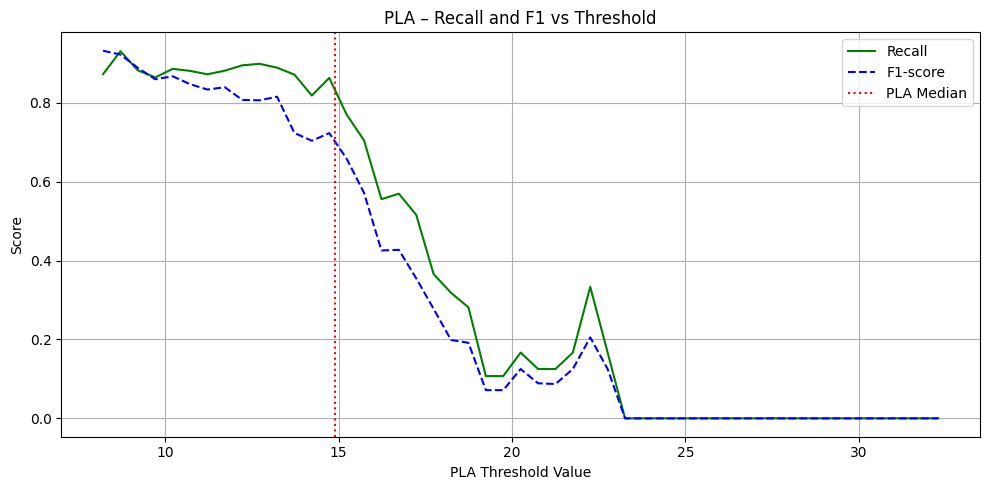

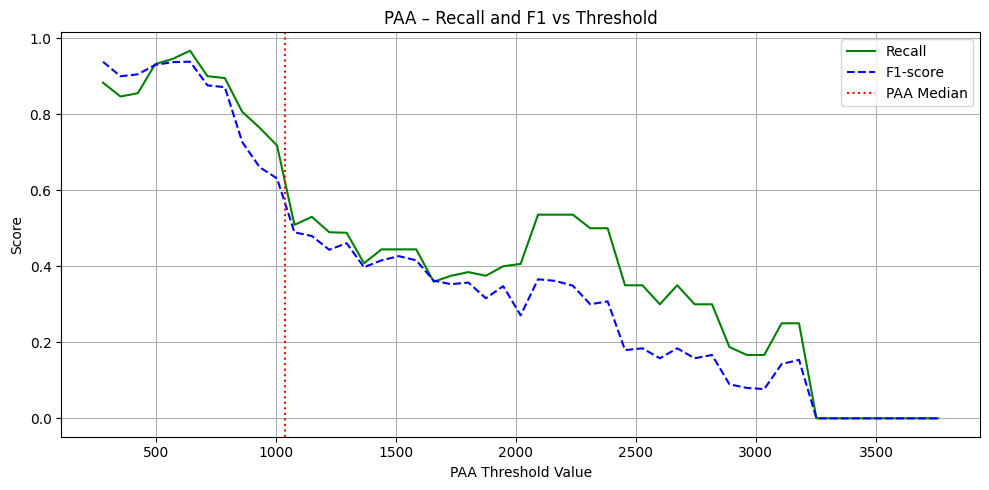

In [ ]:
# --- Graphiques Recall et F1 en fonction du seuil physique ---
plt.figure(figsize=(10, 5))
thresh_L = all_thresholds["Peak Linear Acceleration"]
plt.plot(thresh_L, all_recalls["Peak Linear Acceleration"], label='Recall', color='green')
plt.plot(thresh_L, all_f1s["Peak Linear Acceleration"], label='F1-score', linestyle='--', color='blue')
plt.axvline(x=np.median(df["PLA"].values), color='red', linestyle=':', label='PLA Median')
plt.title("PLA – Recall and F1 vs Threshold")
plt.xlabel("PLA Threshold Value")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
thresh_A = all_thresholds["Peak Angular Acceleration"]
plt.plot(thresh_A, all_recalls["Peak Angular Acceleration"], label='Recall', color='green')
plt.plot(thresh_A, all_f1s["Peak Angular Acceleration"], label='F1-score', linestyle='--', color='blue')
plt.axvline(x=np.median(df["PAA"].values), color='red', linestyle=':', label='PAA Median')
plt.title("PAA – Recall and F1 vs Threshold")
plt.xlabel("PAA Threshold Value")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🎯 Feature ranking pour Peak Linear Acceleration

🔹 Seuil = 1er quartile (10.95)


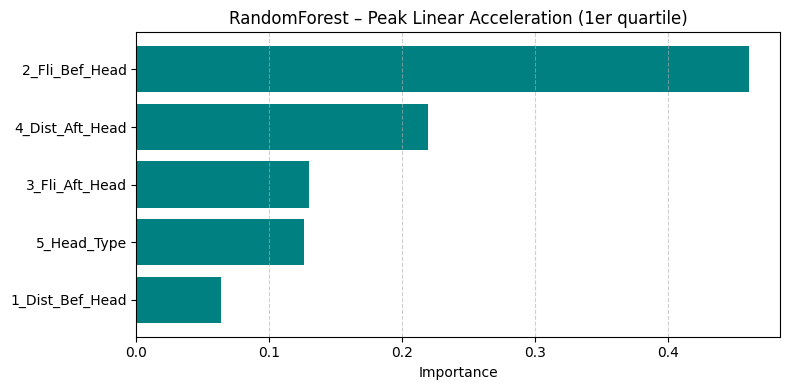

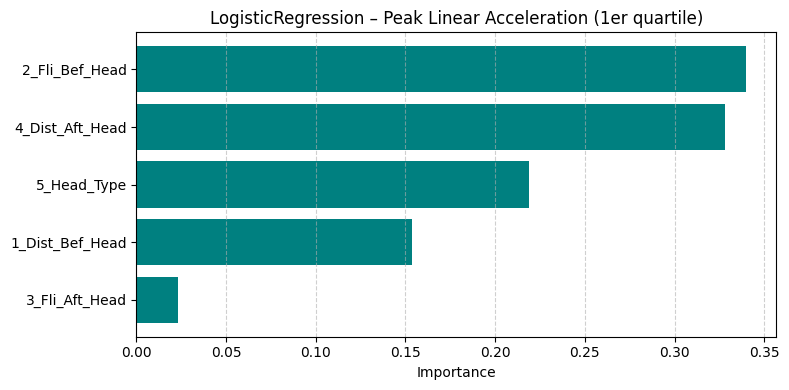

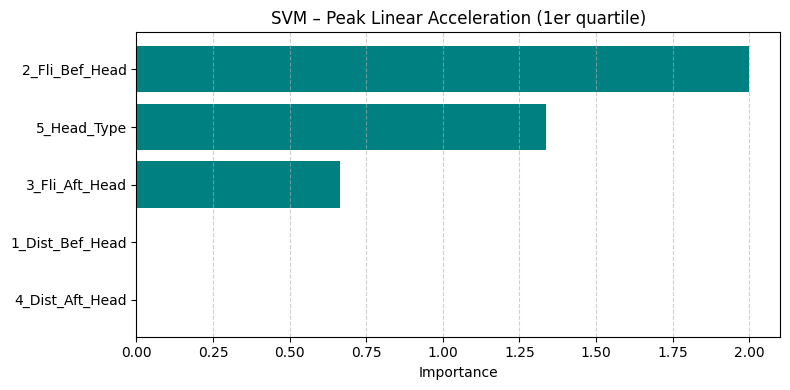

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:03:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


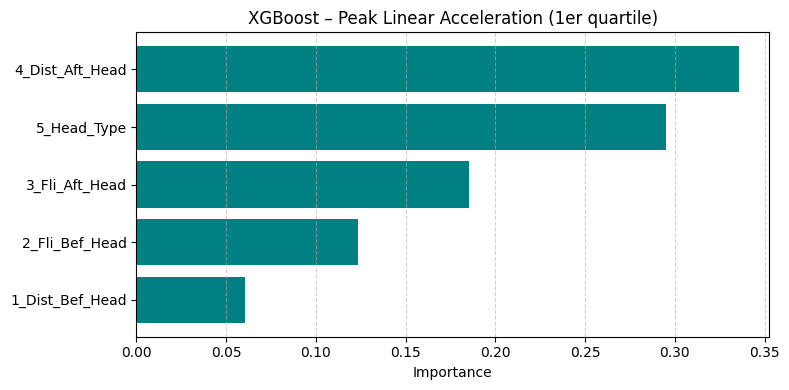


🔹 Seuil = Médiane (14.90)


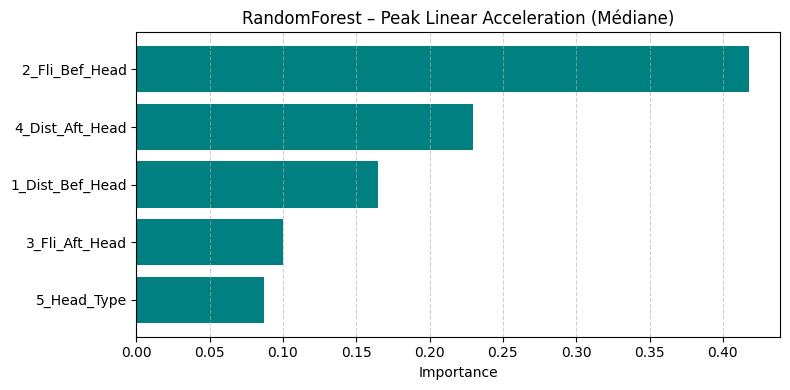

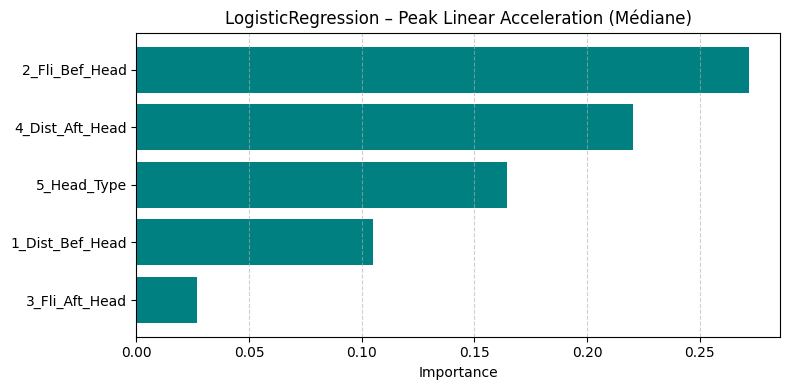

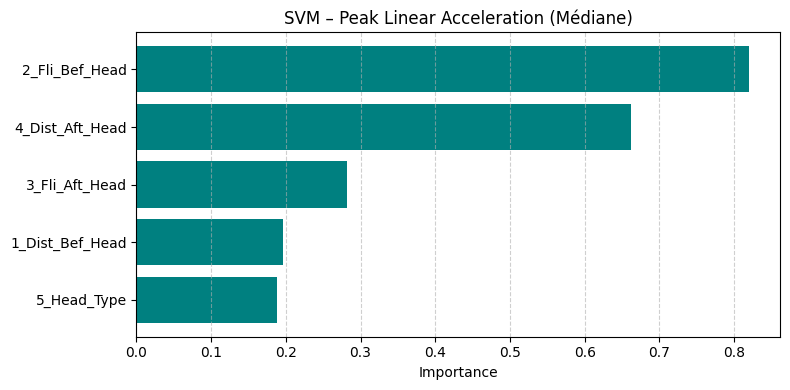

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:03:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


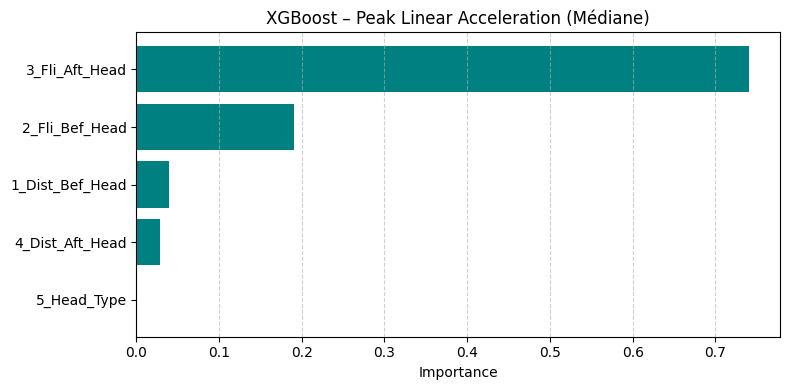


🎯 Feature ranking pour Peak Angular Acceleration

🔹 Seuil = 1er quartile (838.00)


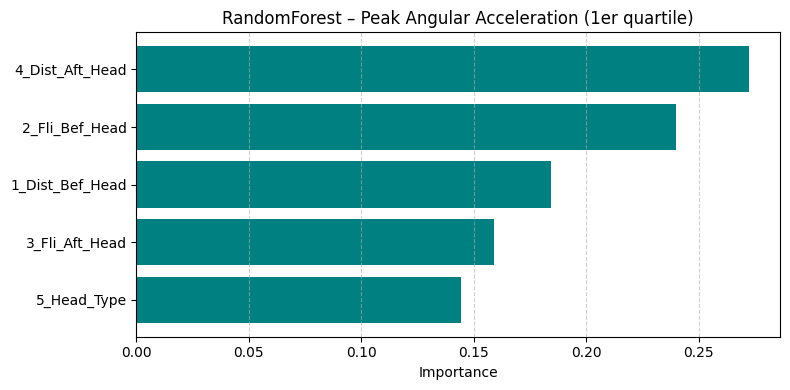

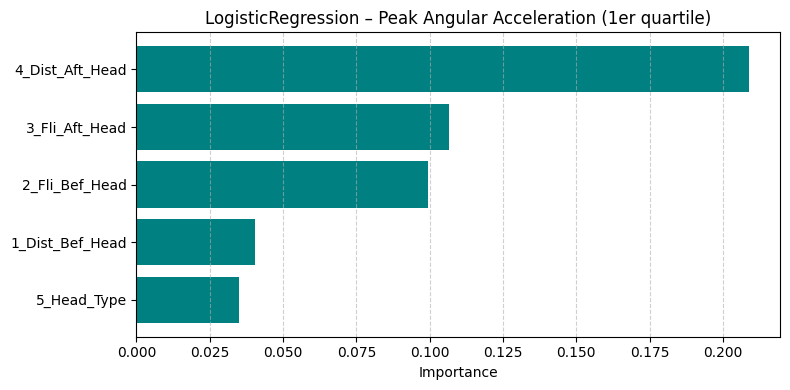

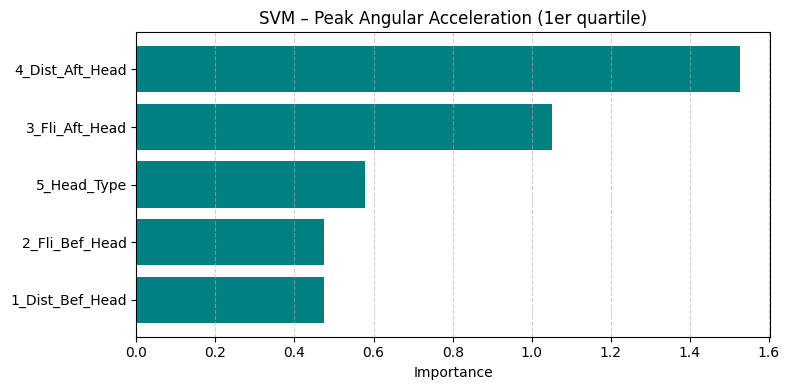

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:03:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


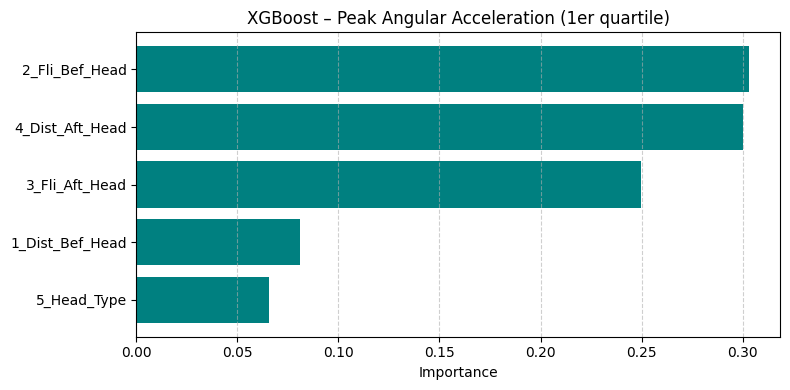


🔹 Seuil = Médiane (1040.00)


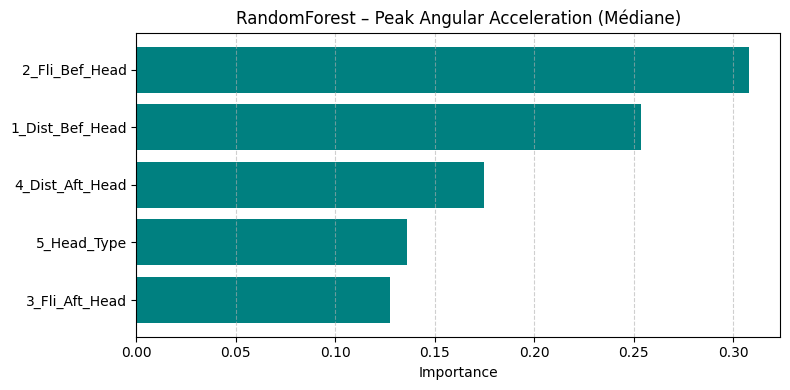

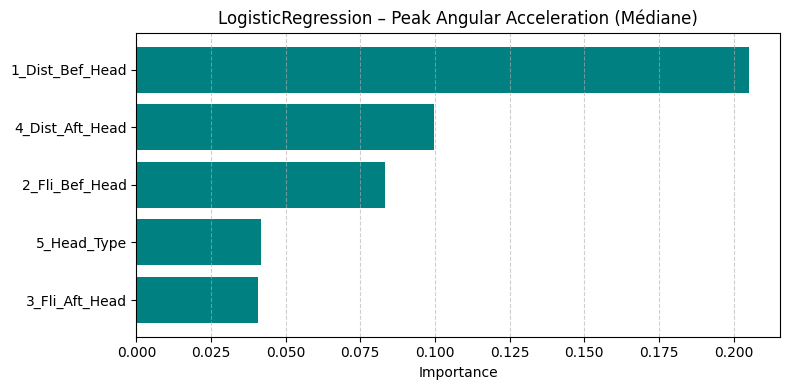

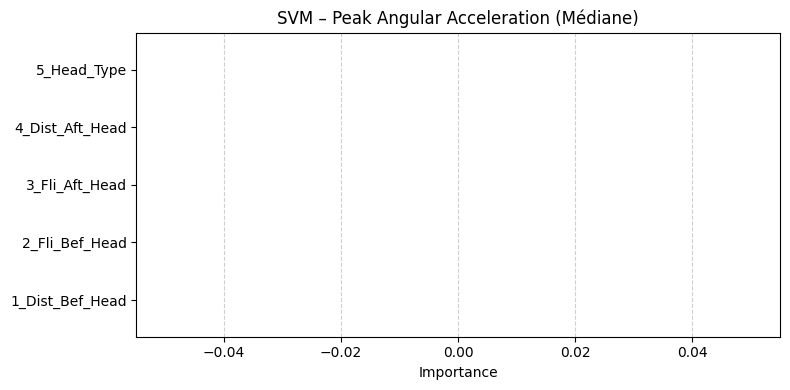

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:03:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


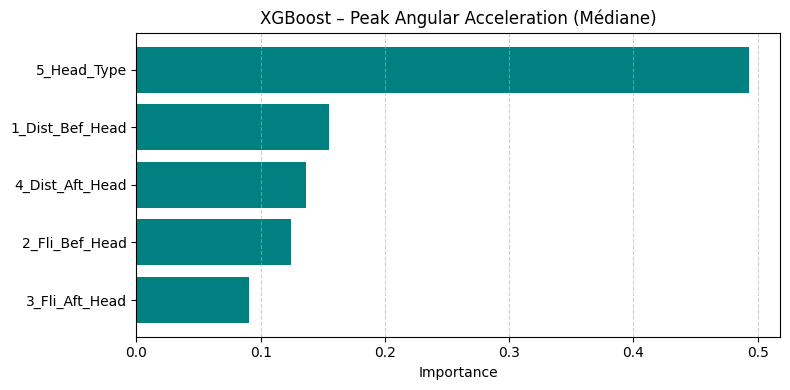

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

models = {
        'RandomForest': (RandomForestClassifier(), {
            'n_estimators': [50, 100],
            'max_depth': [3, 5, None],
            'class_weight': ['balanced']
        }),
        'LogisticRegression': (LogisticRegression(solver='liblinear'), {
            'C': [0.1, 1, 10],
            'class_weight': ['balanced']
        }),
        'SVM': (SVC(probability=True), {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'class_weight': ['balanced']
        }),
        'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {
            'n_estimators': [50, 100],
            'max_depth': [3, 5],
            'scale_pos_weight': [5.0]
        })
    }

# --- Feature ranking avec bar plots ---
for target_var, target_name in [("PLA", "Peak Linear Acceleration"), ("PAA", "Peak Angular Acceleration")]:
    print(f"\n🎯 Feature ranking pour {target_name}")

    thresholds = {
        "1er quartile": np.percentile(df[target_var].values, 25),
        "Médiane": np.median(df[target_var].values)
    }

    for seuil_name, seuil_val in thresholds.items():
        print(f"\n🔹 Seuil = {seuil_name} ({seuil_val:.2f})")
        y_bin_all = (df[target_var].values > seuil_val).astype(int)

        if len(np.unique(y_bin_all)) < 2:
            print("❌ Seulement une classe présente après binarisation. Skip.")
            continue

        for model_name, (clf, param_grid) in models.items():
            X_train, X_test, y_train, y_test = train_test_split(
                X_orig, y_bin_all, test_size=0.2, stratify=y_bin_all, random_state=42
            )

            grid = GridSearchCV(clf, param_grid, cv=3, scoring='recall', n_jobs=-1)
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_

            try:
                if model_name == "LogisticRegression" or (model_name == "SVM" and best_model.kernel == "linear"):
                    importances = np.abs(best_model.coef_).flatten()
                elif model_name == "RandomForest" or model_name == "XGBoost":
                    importances = best_model.feature_importances_
                else:
                    result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
                    importances = result.importances_mean

                feature_ranking = pd.DataFrame({
                    "Feature": X_orig.columns,
                    "Importance": importances
                }).sort_values(by="Importance", ascending=True)

                # --- Bar Plot ---
                plt.figure(figsize=(8, 4))
                plt.barh(feature_ranking["Feature"], feature_ranking["Importance"], color='teal')
                plt.title(f"{model_name} – {target_name} ({seuil_name})")
                plt.xlabel("Importance")
                plt.grid(True, axis='x', linestyle='--', alpha=0.6)
                plt.tight_layout()
                plt.show()

            except Exception as e:
                print(f"⚠️ Impossible de calculer les importances pour {model_name} : {e}")